# Topic Modeling by LDA Model
---

At this notebook you can find realization of classification task by means of topic modeling. We will try to determine `N_MOST_POPULAR` topics according to `N_MOST_POPULAR` tags and then will try to connect topics and tags by probabilities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

In [2]:
module_path = os.path.abspath(os.path.join('..')) # Path to root folder
if module_path not in sys.path:
    sys.path.append(module_path + "/scripts") # define scripts path

from ipynb_func import *

Data loader:

In [3]:
NUM = 10 # Number of data parquets to use
assert NUM >= 1 and NUM <= 10, "NUM value must be in range [1, 10]"

# Making list of roots to merge processed raw data 
#paths = [module_path + f"/data/pikabu/tag_processed/raw_data/{i}_tag_processed.parquet" for i in range(NUM)] 

# Making list of roots to merge processed filtered data
paths = [module_path + f"/data/pikabu/tag_processed/filtered_data/{i}_tag_processed.parquet" for i in range(NUM)] 
data = merge_dataset(paths)

In [4]:
data.head(5)

,text_markdown,tags
15,"[добрый, сутки, господин, дама, подсказывать, ...","[Игры, Поиск]"
37,"[ехать, довезти, девчонка, школа, свободный, м...",[Юмор]
52,"[стадо, стадо, гигантский, случаться, стадо, у...",[Мат]
58,"[бизнесмен, начало, нулевой, заниматься, диск,...","[Люди, Деньги, Мат]"
67,"[ох, сутки, ребята, поговорить, домашний, плюс...",[Мат]


Load model by it's name:

## 1. Model training

In this section, we describe and train an LDA model for the topic classification task through topic modeling. 

In [5]:
from gensim.models.ldamodel import LdaModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [6]:
data_text = [t.tolist() for t in data.text_markdown]
dict = Dictionary(data_text)
corpus = [dict.doc2bow(text) for text in data_text]

We're trying to predict known top tags from original dataset. Let's count their number:

In [7]:
tags_list = getwordlist(data.tags)
tags_list = getworddict(tags_list)
num_topics = len(tags_list)
print('Number of topics to predict:', num_topics)

Number of topics to predict: 54


Model configuration:

In [8]:
np.random.seed(42)

lda_cfg = {'num_topics': num_topics,
           'epochs': 10,
           'chunksize': 100,
           'update_every': 10}

Train model or load already trained model to recalculate some parameters:

In [9]:
a = input('Do you want to train new model? (Y for yes)')
if a == 'Y':
    LDA = LdaModel(corpus=corpus,
                id2word=dict,
                num_topics=lda_cfg['num_topics'],
                passes=lda_cfg['epochs'],
                chunksize=lda_cfg['chunksize'],
                update_every=lda_cfg['update_every'],
                alpha='auto',
                eta='auto')
else:
    model_name = input('Write model name to load:')
    model_path = module_path + '/models/' + model_name
    LDA = LdaModel.load(model_path + '.model')

Working model result:

In [10]:
LDA.show_topics(num_topics=5, formatted=True)

[(50,
  '0.154*"андрей" + 0.075*"миша" + 0.071*"газ" + 0.065*"максим" + 0.056*"мастер" + 0.049*"ольга" + 0.033*"макс" + 0.029*"заебывать" + 0.027*"газовый" + 0.024*"бла"'),
 (41,
  '0.085*"охранник" + 0.048*"желательно" + 0.036*"здание" + 0.035*"кол" + 0.035*"камень" + 0.031*"зеркало" + 0.028*"сибирь" + 0.027*"миф" + 0.027*"военкомат" + 0.027*"психиатр"'),
 (11,
  '0.032*"коронавирус" + 0.026*"муж" + 0.015*"подруга" + 0.013*"месяц" + 0.012*"приезжать" + 0.012*"общаться" + 0.009*"неделя" + 0.009*"знакомый" + 0.008*"общий" + 0.008*"уезжать"'),
 (49,
  '0.052*"пост" + 0.024*"сайт" + 0.023*"читать" + 0.018*"пикабу" + 0.017*"написать" + 0.016*"http" + 0.015*"интернет" + 0.013*"интересный" + 0.013*"ссылка" + 0.013*"комментарий"'),
 (22,
  '0.012*"проблема" + 0.008*"ситуация" + 0.008*"мысль" + 0.007*"любой" + 0.006*"происходить" + 0.006*"отношение" + 0.005*"пытаться" + 0.005*"возможно" + 0.005*"чувство" + 0.005*"хотеться"')]

And now we calculate some of model's metrics:

In [11]:
print('Perplexity of a model:', LDA.log_perplexity(corpus))

Perplexity of a model: -10.604340707625656


In [12]:
coher = CoherenceModel(model=LDA, texts=data_text, dictionary=dict, coherence='c_v')
coher_lda = coher.get_coherence()
print('Coherence of a model:', coher_lda)

Coherence of a model: 0.5274373870753967


In [13]:
top = LDA.top_topics(corpus=corpus)
coh = []
for topic in top:
    for word in topic[0]:
        coh.append(word[0])
coh = np.mean(coh)

print('Mean coherence of a words: ', coh)

Mean coherence of a words:  0.017025884


Save model for future use:

In [14]:
a = input('Are you sure, that you want to save the model? (Y/n)')
if a == 'Y':
    model_path = module_path + '/models/'
    name = input('Name your model:')
    LDA.save(model_path + name +  '.model')

---
## 2. LDA model's analysis

In this section, we will analyze the resulting model and try to match the topics of the model with the existing tags of the dataset.

In [15]:
model_name = 'filtered_lda_model'
model_path = module_path + '/models/' + model_name
LDA = LdaModel.load(model_path + '.model')

Let's assign the numbers of the most likely predicted topics to the posts in the dataset, the probability of which exceeds the `THRESHOLD`:

In [16]:
THRESHOLD = 0.15

corpus_topics = []
for sentence in corpus:
    topics = LDA.get_document_topics(sentence)
    topics = sorted(topics, key=lambda x: x[1], reverse=True)
    topics_for_sentence = []
    for i in range(len(topics)):
        if topics[i][1] > THRESHOLD:
            topics_for_sentence.append(topics[i][0])
    corpus_topics.append(topics_for_sentence)

data['corpus_topics'] = corpus_topics

As the result, we have following data:

In [17]:
data.head(5)

,text_markdown,tags,corpus_topics
15,"[добрый, сутки, господин, дама, подсказывать, ...","[Игры, Поиск]","[9, 3, 18]"
37,"[ехать, довезти, девчонка, школа, свободный, м...",[Юмор],"[18, 48]"
52,"[стадо, стадо, гигантский, случаться, стадо, у...",[Мат],[25]
58,"[бизнесмен, начало, нулевой, заниматься, диск,...","[Люди, Деньги, Мат]","[39, 22]"
67,"[ох, сутки, ребята, поговорить, домашний, плюс...",[Мат],[22]


Let's use pyLDAvis for visuallization of `model_name` LDA model:

In [18]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(LDA, corpus, dict)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22     0.014887 -0.198798       1        1  9.225195
5      0.174265 -0.067732       2        1  6.280405
28    -0.125046 -0.144893       3        1  5.302227
8      0.173826 -0.028986       4        1  4.883153
43     0.134231 -0.097888       5        1  4.440450
11     0.146440 -0.129145       6        1  3.694692
17     0.169170  0.022677       7        1  3.518280
18     0.169968 -0.078107       8        1  3.376787
16     0.167219 -0.064558       9        1  3.137074
4      0.241979 -0.029055      10        1  3.084457
39    -0.251990 -0.128165      11        1  2.656460
49    -0.013404 -0.104789      12        1  2.399899
32    -0.250214 -0.087401      13        1  2.311875
37    -0.034314 -0.054285      14        1  2.071616
14    -0.073778 -0.117600      15        1  2.026501
52     0.077785 -0.041184      16        1  1.927154
23    -0.229032 -0.091305      17        1  1.886522
31     0.002305 -0.090716      18        1  1.878504
46     0.202941 -0.018620      19        1  1.868586
20    -0.035761 -0.141642      20        1  1.813769
53     0.086545 -0.020077      21        1  1.784197
33    -0.102639 -0.131344      22        1  1.759607
12     0.086300 -0.080132      23        1  1.745476
29    -0.241335 -0.057599      24        1  1.496364
40    -0.098358 -0.127887      25        1  1.400816
13     0.013518 -0.054575      26        1  1.392014
3      0.002155 -0.053532      27        1  1.381830
48    -0.041560  0.010045      28        1  1.282957
15    -0.116156 -0.080628      29        1  1.234004
36    -0.060411 -0.006136      30        1  1.232382
27     0.085603  0.062267      31        1  1.185081
1      0.089707 -0.027378      32        1  1.138187
2     -0.209958  0.006940      33        1  1.118870
0      0.041959  0.089356      34        1  1.085543
51    -0.070853 -0.009977      35        1  1.071226
38     0.049726 -0.002199      36        1  1.038171
21     0.141665  0.051538      37        1  1.034864
7      0.087062 -0.031885      38        1  0.977284
45     0.034480  0.115105      39        1  0.955259
30     0.066662  0.074703      40        1  0.938055
35     0.060622  0.084172      41        1  0.775959
9      0.022703  0.031560      42        1  0.741340
47     0.000624  0.075358      43        1  0.715681
6     -0.126450  0.133043      44        1  0.631713
34     0.020802  0.171258      45        1  0.530440
10     0.037656  0.149545      46        1  0.521786
42    -0.077759  0.171715      47        1  0.514397
26    -0.110413  0.083030      48        1  0.465777
24    -0.130206  0.173414      49        1  0.445195
44    -0.038066  0.105767      50        1  0.429450
25    -0.005986  0.207094      51        1  0.336558
19    -0.044217  0.197114      52        1  0.324196
50    -0.050262  0.185294      53        1  0.274849
41    -0.064634  0.197223      54        1  0.256864, topic_info=              Term         Freq        Total Category  logprob  loglift
423        девушка  8891.000000  8891.000000  Default  30.0000  30.0000
550           мама  8107.000000  8107.000000  Default  29.0000  29.0000
18         телефон  4731.000000  4731.000000  Default  28.0000  28.0000
7             игра  3782.000000  3782.000000  Default  27.0000  27.0000
42           школа  4570.000000  4570.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
3012        камень   285.898028  1080.330634  Topic54  -3.3599   4.6350
1650        охрана   182.272491   619.724807  Topic54  -3.8101   4.7406
4527  перепутывать    85.251940   202.531282  Topic54  -4.5700   5.0991
5430        пузырь    80.215980   214.728409  Topic54  -4.6308   4.9797
2393           мед    73.065386   206.827483  Topic54  -4.7242   4.9238

[2977 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4786     32  0.823437    hr
274

And see topics distribution of `model_name` topics:

In [19]:
corp = getwordlist(data.corpus_topics)
corp = getworddict(corp, reverse=False)

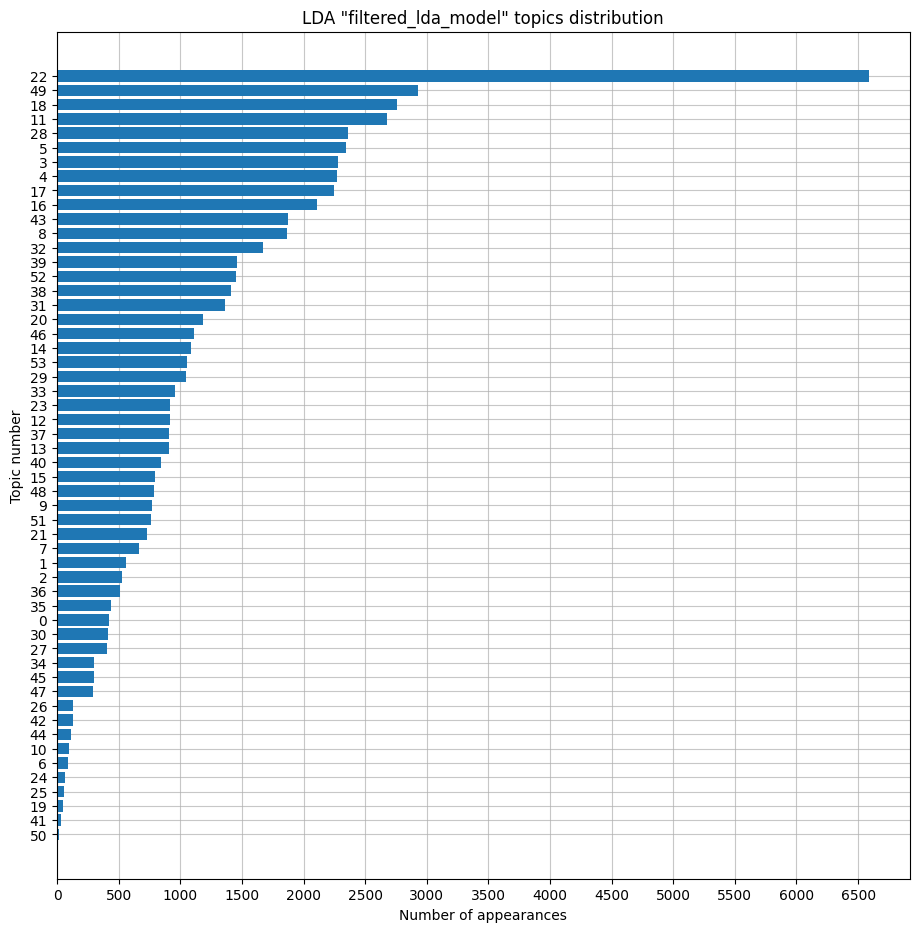

In [20]:
corp_w = list(map(str, corp.keys()))
corp_c = list(corp.values())

raw_fig, ax = plt.subplots(figsize=(11, 11))

ax.grid(zorder=1, alpha=0.7)
ax.barh(corp_w, corp_c, zorder=2)
ax.set_xticks(np.arange(0, max(corp_c), 500))
ax.set_xlabel("Number of appearances")
ax.set_ylabel("Topic number")
ax.set_title(f"LDA \"{model_name}\" topics distribution");

Based on this distribution, we will assume that the topics in the model are distributed approximately the same as the tags in the data (if we look at the graphs in `dataset_tag_analysis.ipynb`, there are actually similarities). So, we will assign a tag name to each topic in the model in accordance with the distributions (that is, we will sort in descending order the frequency of use of tags and model topics and assign a tag to the corresponding topic):

In [21]:
topic_names = {}
for topic_id, topic_name in zip(corp.keys(), tags_list.keys()):
    topic_names[topic_id] = topic_name

As the result, we have the following:

In [22]:
new_topics = [[topic_names[topic_id] for topic_id in topic] for topic in data.corpus_topics]
data_copy = data.copy()
data_copy.corpus_topics = new_topics

In [23]:
pd.set_option('display.max_colwidth', 200)
data_copy.head(2)

,text_markdown,tags,corpus_topics
15,"[добрый, сутки, господин, дама, подсказывать, название, игра, телефон, оформление, смахивать, убийство, зомби, очки, ездить, машинка, крутить, развивать, скорость, заранее, благодарить]","[Игры, Поиск]","[Карантин, Музыка, Новый Год]"
37,"[ехать, довезти, девчонка, школа, свободный, макс, заявка, прямой, конечный, адрес, железнодорожный, институт, включать, вбивать, адрес, выдавать, столовая, ладно, садиться, уточнять, садиться, пе...",[Юмор],"[Новый Год, Девушки]"


And the accuracy of the model is equal to:

In [27]:
count = 0
total_count = 0
for true_tags, pred_tags in zip(data_copy.tags, data_copy.corpus_topics):
    total_count += 1
    for pred_tag in pred_tags:
        if pred_tag in true_tags:
            count += 1
print(f'\'{model_name}\' model\'s accuracy: {count/total_count:.4f}')

'filtered_lda_model' model's accuracy: 0.0284


Thus, we can say that either the assumption turned out to be incorrect, or we need to try to train the model on other data and/or other settings  (╯°□°）╯︵ ┻━┻